In [15]:
from unidecode import unidecode

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 1. Importação e junção dos datasets

## 1.1. Dados de Internet

### SIMET_VELOC
- **cod_setor:** setor censitário da região avaliada.
- **lat, lon:** coordenadas geográficas.
- **asn:** código da operadora.
- **asn_name:** nome da operadora.
- **type:** tipo de conexão -- *broadband* para banda-larga fixa, *mobile* para banda-larga móvel.
- **numDisps:** número de dispositivos que compõem a amostra.
- **tcp_range_(velocidade):** número de dispositivos por faixa de velocidade de download, em Mb/s.

### DIC_IBGE
- **cod_setor:** setor censitário da região.
- **cod_ap:** área de ponderação da região.
- **cod_mun:** código do município.
- **nom_mun:** nome completo do município.
- **sig_uf:** sigla da unidade federativa.

Os códigos de geolocalização `cod_mun`, `cod_ap` e `cod_setor` são compilados pelo IBGE e disponibilizados na página sobre [Malha de Setores Censitários](https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/26565-malhas-de-setores-censitarios-divisoes-intramunicipais.html?=&t=o-que-e).

In [29]:
def classifica_uf(x):
    if x in ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']:
        return 'NORTE'
    if x in ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']:
        return 'NORDESTE'
    if x in ['MT', 'MS', 'GO', 'DF']:
        return 'CENTRO-OESTE'
    if x in ['MG', 'SP', 'RJ', 'ES']:
        return 'SUDESTE'
    if x in ['SC', 'PR', 'RS']:
        return 'SUL'

In [84]:
def soma_tcp_range(df, start, stop):
    col_soma = pd.Series(np.zeros(len(df)))
    
    while start <= stop:
        try:
            col_soma += df['tcp_range_' + str(start)]
        except KeyError:
            pass
        start += 0.5
        
    return col_soma

### 1.1.1 Importação e geolocalização

In [79]:
internet_connection = pd.read_parquet('datasets/raw/internet_connection.parquet')
display(internet_connection.head())

dicionario_ibge = pd.read_parquet('datasets/raw/dicionario_ibge.parquet')
display(dicionario_ibge.head())

,cod_setor,asn,asn_name,type,numDisps,"tcp_range_0,5",tcp_range_1,"tcp_range_1,5",tcp_range_2,"tcp_range_2,5",...,tcp_range_10,tcp_range_11,tcp_range_12,tcp_range_15,tcp_range_20,tcp_range_25,tcp_range_35,tcp_range_40,tcp_range_45,tcp_range_50
0,330070405000288,NaN,Todos ASN,broadband,4,0,0,0,0,NaN,...,0,NaN,NaN,1,1.0,0.0,0.0,NaN,NaN,1.0
1,330070405000288,18881.0,TELEFONICA BRASIL S.A,broadband,1,0,0,0,0,NaN,...,0,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,1.0
2,330070405000288,28210.0,VM OPENLINK COMUNICACAO MULTIMIDIA S.A.,broadband,1,0,0,0,0,NaN,...,0,NaN,NaN,1,0.0,0.0,0.0,NaN,NaN,0.0
3,330070405000288,267416.0,PIENSCO MANUTENCAO E PROJETOS LTDA,broadband,1,0,0,0,0,NaN,...,0,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,0.0
4,330070405000288,7738.0,Telemar Norte Leste S.A.,broadband,1,0,0,0,0,NaN,...,0,NaN,NaN,0,1.0,0.0,0.0,NaN,NaN,0.0


,cod_setor,cod_ap,cod_mun,nom_mun,sig_uf
0,120001305000011,1.200013e+12,1200013,ACRELANDIA,AC
1,120001305000006,1.200013e+12,1200013,ACRELANDIA,AC
2,120001305000010,1.200013e+12,1200013,ACRELANDIA,AC
3,120001305000002,1.200013e+12,1200013,ACRELANDIA,AC
4,120001305000016,1.200013e+12,1200013,ACRELANDIA,AC


In [80]:
dicionario_ibge['nom_mun'] = dicionario_ibge['nom_mun'].apply(lambda x: unidecode(x))
dicionario_ibge['regiao'] = dicionario_ibge['sig_uf'].apply(classifica_uf)
internet_connection.columns = internet_connection.columns.str.replace(',', '.')
internet_connection = internet_connection.rename(columns=dict(
    zip(
        [x for x in internet_connection.columns if 'tcp_range' in x and '.' not in x],
        [x + str('.0') for x in internet_connection.columns if 'tcp_range' in x and '.' not in x]
    )
))
internet_connection = internet_connection.merge(dicionario_ibge, how='inner', on='cod_setor')
internet_connection.head()

,cod_setor,asn,asn_name,type,numDisps,tcp_range_0.5,tcp_range_1.0,tcp_range_1.5,tcp_range_2.0,tcp_range_2.5,...,tcp_range_25.0,tcp_range_35.0,tcp_range_40.0,tcp_range_45.0,tcp_range_50.0,cod_ap,cod_mun,nom_mun,sig_uf,regiao
0,330070405000288,NaN,Todos ASN,broadband,4,0,0,0,0,NaN,...,0.0,0.0,NaN,NaN,1.0,3.300704e+12,3300704,CABO FRIO,RJ,SUDESTE
1,330070405000288,18881.0,TELEFONICA BRASIL S.A,broadband,1,0,0,0,0,NaN,...,0.0,0.0,NaN,NaN,1.0,3.300704e+12,3300704,CABO FRIO,RJ,SUDESTE
2,330070405000288,28210.0,VM OPENLINK COMUNICACAO MULTIMIDIA S.A.,broadband,1,0,0,0,0,NaN,...,0.0,0.0,NaN,NaN,0.0,3.300704e+12,3300704,CABO FRIO,RJ,SUDESTE
3,330070405000288,267416.0,PIENSCO MANUTENCAO E PROJETOS LTDA,broadband,1,0,0,0,0,NaN,...,0.0,0.0,NaN,NaN,0.0,3.300704e+12,3300704,CABO FRIO,RJ,SUDESTE
4,330070405000288,7738.0,Telemar Norte Leste S.A.,broadband,1,0,0,0,0,NaN,...,0.0,0.0,NaN,NaN,0.0,3.300704e+12,3300704,CABO FRIO,RJ,SUDESTE


### 1.1.2. Agregação por município
Aqui, agrupamos os registros por município e tipo de conexão, e somamos o total de dispositivos por faixa de velocidade (`tcp_range_...`).

In [88]:
tcp_range_cols = [x for x in internet_connection.columns.tolist() if 'tcp_range' in x]
agg_dict = {key: 'sum' for key in tcp_range_cols}
agg_dict['asn_name'] = 'nunique'

internet_connection_grp = internet_connection.groupby(['cod_mun', 'type', 'nom_mun', 'sig_uf', 'regiao']).agg(agg_dict).reset_index().rename(columns={'asn_name': 'num_operadoras'})
internet_connection_grp.head()

,cod_mun,type,nom_mun,sig_uf,regiao,tcp_range_0.5,tcp_range_1.0,tcp_range_1.5,tcp_range_2.0,tcp_range_2.5,...,tcp_range_11.0,tcp_range_12.0,tcp_range_15.0,tcp_range_20.0,tcp_range_25.0,tcp_range_35.0,tcp_range_40.0,tcp_range_45.0,tcp_range_50.0,num_operadoras
0,1100015,broadband,ALTA FLORESTA D'OESTE,RO,NORTE,26,0,0,0,0.0,...,0.0,0.0,0,0.0,0.0,22.0,0.0,0.0,0.0,3
1,1100023,broadband,ARIQUEMES,RO,NORTE,20,34,0,0,0.0,...,0.0,0.0,12,36.0,27.0,66.0,0.0,0.0,96.0,7
2,1100023,mobile,ARIQUEMES,RO,NORTE,0,0,0,0,0.0,...,0.0,10.0,22,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1100049,broadband,CACOAL,RO,NORTE,0,0,26,32,0.0,...,0.0,0.0,0,0.0,42.0,84.0,0.0,0.0,340.0,5
4,1100049,mobile,CACOAL,RO,NORTE,16,0,0,0,0.0,...,0.0,0.0,32,0.0,0.0,0.0,0.0,0.0,0.0,3


### 1.1.3. Agregação por faixas amplas de velocidade

In [89]:
internet_connection_grp['0_a_2_mbs'] = soma_tcp_range(internet_connection_grp, 0, 2)
internet_connection_grp['2.5_a_5_mbs'] = soma_tcp_range(internet_connection_grp, 2.5, 5)
internet_connection_grp['6_a_10_mbs'] = soma_tcp_range(internet_connection_grp, 6, 10)
internet_connection_grp['11_a_15_mbs'] = soma_tcp_range(internet_connection_grp, 11, 15)
internet_connection_grp['15_a_25_mbs'] = soma_tcp_range(internet_connection_grp, 16, 25)
internet_connection_grp['acima_25_mbs'] = soma_tcp_range(internet_connection_grp, 26, 50)

In [90]:
internet_connection_grp = internet_connection_grp.drop(columns=[x for x in internet_connection_grp if 'tcp_range' in x])
internet_connection_grp.head()

,cod_mun,type,nom_mun,sig_uf,regiao,num_operadoras,0_a_2_mbs,2.5_a_5_mbs,6_a_10_mbs,11_a_15_mbs,15_a_25_mbs,acima_25_mbs
0,1100015,broadband,ALTA FLORESTA D'OESTE,RO,NORTE,3,26.0,0.0,0.0,0.0,0.0,22.0
1,1100023,broadband,ARIQUEMES,RO,NORTE,7,54.0,94.0,86.0,12.0,63.0,162.0
2,1100023,mobile,ARIQUEMES,RO,NORTE,1,0.0,14.0,24.0,32.0,0.0,0.0
3,1100049,broadband,CACOAL,RO,NORTE,5,58.0,72.0,0.0,0.0,42.0,424.0
4,1100049,mobile,CACOAL,RO,NORTE,3,16.0,32.0,0.0,32.0,0.0,0.0


## 1.2. Dados de Educação

### DIC_IBGE
- **cod_setor:** setor censitário da região.
- **cod_ap:** área de ponderação da região.
- **cod_mun:** código do município.
- **nom_mun:** nome completo do município.
- **sig_uf:** sigla da unidade federativa.

Os códigos de geolocalização `cod_mun`, `cod_ap` e `cod_setor` são compilados pelo IBGE e disponibilizados na página sobre [Malha de Setores Censitários](https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/26565-malhas-de-setores-censitarios-divisoes-intramunicipais.html?=&t=o-que-e).
Este dataframe é o mesmo utilizado na seção anterior.

In [91]:
def remove_multilevel_index(df):
    for i in range(len(df.columns.values)):
        col = list(df.columns.values[i])

        # Transforma títulos em string
        for j in range(3):
            col[j] = str(col[j])

        # Retira títulos vazios
        for j in range(3):
            if 'Unnamed' in col[j]:
                col[j] = ""

        col = tuple(col)
        df.columns.values[i] = col

    # Junta os títulos hierárquicos em um só
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    
    return df

### 1.2.1. IDEB para anos iniciais

In [92]:
dados_ideb_ef_1 = pd.read_excel('datasets/raw/divulgacao_anos_iniciais_municipios_2019.xlsx',
                                header = [6, 7, 8])

dados_ideb_ef_1 = remove_multilevel_index(dados_ideb_ef_1)
dados_ideb_ef_1 = dados_ideb_ef_1[dados_ideb_ef_1['Rede'] == 'Pública'][[
    'Código do Município',
    'Taxa de Aprovação - 2019  5º',
    'Nota SAEB - 2019 Matemática',
    'Nota SAEB - 2019 Língua Portuguesa',
    'IDEB\n2019\n(N x P)'
]].rename(columns={
    'Código do Município': 'cod_mun',
    'Taxa de Aprovação - 2019  5º': 'tx_aprov_ef_1',
    'Nota SAEB - 2019 Matemática': 'saeb_mat_ef_1',
    'Nota SAEB - 2019 Língua Portuguesa': 'saeb_port_ef_1',
    'IDEB\n2019\n(N x P)': 'ideb_ef_1'
}).reset_index(drop=True)

dados_ideb_ef_1.head()

,cod_mun,tx_aprov_ef_1,saeb_mat_ef_1,saeb_port_ef_1,ideb_ef_1
0,1100015,92.4,226.44,204.7,5.7
1,1100023,88.7,214.18,199.92,5.2
2,1100031,86.8,216.56,201.97,5.1
3,1100049,98,223.45,209.48,5.8
4,1100056,97.8,245.81,227.03,6.4


In [93]:
#Importa dados do IDEB (anos finais)
dados_ideb_ef_2 = pd.read_excel('datasets/raw/divulgacao_anos_finais_municipios_2019.xlsx',
                                header = [6, 7, 8])

dados_ideb_ef_2 = remove_multilevel_index(dados_ideb_ef_2)
dados_ideb_ef_2 = dados_ideb_ef_2[dados_ideb_ef_2['Rede'] == 'Pública'][[
    'Código do Município',
    'Taxa de Aprovação - 2019  9º',
    'Nota SAEB - 2019 Matemática',
    'Nota SAEB - 2019 Língua Portuguesa',
    'IDEB\n2019\n(N x P)'
]].rename(columns={
    'Código do Município': 'cod_mun',
    'Taxa de Aprovação - 2019  9º': 'tx_aprov_ef_2',
    'Nota SAEB - 2019 Matemática': 'saeb_mat_ef_2',
    'Nota SAEB - 2019 Língua Portuguesa': 'saeb_port_ef_2',
    'IDEB\n2019\n(N x P)': 'ideb_ef_2'
}).reset_index(drop=True)

dados_ideb_ef_2.head()

,cod_mun,tx_aprov_ef_2,saeb_mat_ef_2,saeb_port_ef_2,ideb_ef_2
0,1100015,95.3,270.02,265.1,5.2
1,1100023,93.7,266.09,265.26,5.1
2,1100031,94.2,242.44,241.04,4.6
3,1100049,98.3,267.51,260.58,5.3
4,1100056,97.3,268.57,261.62,5.3


In [94]:
#Importa dados do IDEB (ensino médio)
dados_ideb_em = pd.read_excel('datasets/raw/divulgacao_ensino_medio_municipios_2019.xlsx',
                              header = [6, 7, 8])

dados_ideb_em = remove_multilevel_index(dados_ideb_em)
dados_ideb_em = dados_ideb_em[dados_ideb_em['Rede'] == 'Pública'][[
    'Código do Município',
    'Taxa de Aprovação - 2019  Total',
    'Nota SAEB - 2019 Matemática',
    'Nota SAEB - 2019 Língua Portuguesa',
    'IDEB\n2019\n(N x P)'
]].rename(columns={
    'Código do Município': 'cod_mun',
    'Taxa de Aprovação - 2019  Total': 'tx_aprov_em',
    'Nota SAEB - 2019 Matemática': 'saeb_mat_em',
    'Nota SAEB - 2019 Língua Portuguesa': 'saeb_port_em',
    'IDEB\n2019\n(N x P)': 'ideb_em'
}).reset_index(drop=True)

dados_ideb_em.head()

,cod_mun,tx_aprov_em,saeb_mat_em,saeb_port_em,ideb_em
0,1100015,92.2,285.14,278.52,4.5
1,1100023,83.4,278.58,278.78,4
2,1100031,94.8,ND,ND,-
3,1100049,91.5,282.99,278.36,4.4
4,1100056,90.7,288.99,283.11,4.6


## 1.3. Indicadores sociais

In [95]:
#Importa variáveis de controle para os municípios
indicadores_sociais = pd.read_csv("datasets/raw/indicadores_sociais.csv",
                                  sep = ',')
censo_populacao = pd.read_excel('datasets/raw/pop_censo_2010.xlsx')

#Vamos selecionar variáveis de anos diferentes:
#Censo 2010 (% de pobres, taxa de analfabetismo)
#DataSUS 2017 (Taxa de mortalidade infantil, % de meninas que tiveram filhos)
#RAIS 2016 (PIB per capita)
indicadores_sociais = indicadores_sociais.merge(censo_populacao, on='Territorialidades', how='inner')
indicadores_sociais = indicadores_sociais[[
    'Territorialidades',
    'População total 2010',
    'Esperança de vida ao nascer 2010',
    'Taxa de analfabetismo - 15 anos ou mais de idade 2010',
    '% de pobres 2010', 
    'Produto Interno Bruto per capita 2016',
    'Taxa de mortalidade infantil 2017',
    '% de meninas de 10 a 14 anos de idade que tiveram filhos 2017'
]].rename(columns={
    'Territorialidades': 'nom_mun',
    'População total 2010': 'populacao',
    'Esperança de vida ao nascer 2010': 'exp_vida',
    'Taxa de analfabetismo - 15 anos ou mais de idade 2010': 'analfabetismo',
    '% de pobres 2010': 'tx_pobreza',
    'Produto Interno Bruto per capita 2016': 'pib_per_capita',
    'Taxa de mortalidade infantil 2017': 'mortalidade_inf',
    '% de meninas de 10 a 14 anos de idade que tiveram filhos 2017': 'maternidade_inf'
}).reset_index(drop=True)

indicadores_sociais['sig_uf'] = indicadores_sociais['nom_mun'].apply(lambda x: str(x)[-3:-1])
indicadores_sociais['nom_mun'] = indicadores_sociais['nom_mun'].apply(lambda x: unidecode(str(x)[:-5].upper()))

indicadores_sociais.head()

,nom_mun,populacao,exp_vida,analfabetismo,tx_pobreza,pib_per_capita,mortalidade_inf,maternidade_inf,sig_uf
0,B,190755799,73.94,9.61,15.20,20.19,12.38,0.76,si
1,ABADIA DE GOIAS,6876,74.82,7.81,6.18,13.72,20.41,0.51,GO
2,ABADIA DOS DOURADOS,6704,75.35,9.12,7.94,16.99,0.00,NaN,MG
3,ABADIANIA,15757,75.46,10.84,8.45,10.38,19.61,1.47,GO
4,ABAETE,22690,75.90,8.72,6.69,12.12,12.30,0.41,MG


### Juntando tudo

In [96]:
df = dados_ideb_ef_1.merge(dados_ideb_ef_2, on='cod_mun', how='inner')\
                    .merge(dados_ideb_em, on='cod_mun', how='inner')\
                    .merge(dicionario_ibge.drop(columns=['cod_ap', 'cod_setor']).drop_duplicates(), on='cod_mun', how='inner')\
                    .merge(indicadores_sociais, on=['nom_mun', 'sig_uf'], how='inner')\
                    .merge(internet_connection_grp, on=['cod_mun', 'nom_mun', 'sig_uf', 'regiao'], how='inner')

df = df.reindex(columns=(
    ['cod_mun', 'nom_mun', 'sig_uf', 'regiao'] + list(
        [x for x in df.columns.tolist() if x not in ['cod_mun', 'nom_mun', 'sig_uf', 'regiao']]
    )
))

df.to_csv('datasets/dataset_pre_limpeza.csv', index=False)
df.head()

,cod_mun,nom_mun,sig_uf,regiao,tx_aprov_ef_1,saeb_mat_ef_1,saeb_port_ef_1,ideb_ef_1,tx_aprov_ef_2,saeb_mat_ef_2,...,mortalidade_inf,maternidade_inf,type,num_operadoras,0_a_2_mbs,2.5_a_5_mbs,6_a_10_mbs,11_a_15_mbs,15_a_25_mbs,acima_25_mbs
0,1100015,ALTA FLORESTA D'OESTE,RO,NORTE,92.4,226.44,204.7,5.7,95.3,270.02,...,14.12,0.28,broadband,3,26.0,0.0,0.0,0.0,0.0,22.0
1,1100023,ARIQUEMES,RO,NORTE,88.7,214.18,199.92,5.2,93.7,266.09,...,13.34,0.70,broadband,7,54.0,94.0,86.0,12.0,63.0,162.0
2,1100023,ARIQUEMES,RO,NORTE,88.7,214.18,199.92,5.2,93.7,266.09,...,13.34,0.70,mobile,1,0.0,14.0,24.0,32.0,0.0,0.0
3,1100049,CACOAL,RO,NORTE,98,223.45,209.48,5.8,98.3,267.51,...,9.64,0.34,broadband,5,58.0,72.0,0.0,0.0,42.0,424.0
4,1100049,CACOAL,RO,NORTE,98,223.45,209.48,5.8,98.3,267.51,...,9.64,0.34,mobile,3,16.0,32.0,0.0,32.0,0.0,0.0


# 2. Limpeza dos dados

In [68]:
df = pd.read_csv('datasets/dataset_pre_limpeza.csv')

## 2.1. Dados de educação

In [69]:
cols_educacao = [
    'tx_aprov_ef_1',
    'saeb_mat_ef_1',
    'saeb_port_ef_1',
    'ideb_ef_1',
    'tx_aprov_ef_2',
    'saeb_mat_ef_2',
    'saeb_port_ef_2',
    'ideb_ef_2',
    'tx_aprov_em',
    'saeb_mat_em',
    'saeb_port_em',
    'ideb_em'
]

for col in cols_educacao:
    # Padroniza linhas vazias
    df[col] = df[col].replace('-', np.nan)
    df[col] = df[col].replace('ND', np.nan)
    df[col] = df[col].astype(float)

## 2.2. Indicadores sociais

In [70]:
cols_social = [
    'populacao',
    'exp_vida',
    'analfabetismo',
    'tx_pobreza',
    'pib_per_capita',
    'mortalidade_inf',
    'maternidade_inf'
]

for col in cols_social:
    # Padroniza linhas vazias
    df[col] = df[col].fillna(np.nan)
    df[col] = df[col].astype(float)

## 2.3. Dados de internet

In [71]:
cols_internet = [x for x in df.columns.tolist() if 'mbs' in x]

for col in cols_internet:
    # Padroniza linhas vazias
    df[col] = df[col].fillna(0)
    df[col] = df[col].astype(float)
    
    # Normaliza contagem de dispositivos pela população
    df[col] = df[col] / df['populacao']
    
df['num_operadoras'] = df['num_operadoras'].fillna(0).astype(float)

## 2.4. Salva o DF limpo para analisar

In [7]:
df.to_parquet('datasets/dataset_pos_limpeza.parquet', index=False)
df.head()

,cod_mun,nom_mun,sig_uf,regiao,tx_aprov_ef_1,saeb_mat_ef_1,saeb_port_ef_1,ideb_ef_1,tx_aprov_ef_2,saeb_mat_ef_2,...,mortalidade_inf,maternidade_inf,type,num_operadoras,0_a_2_mbs,2.5_a_5_mbs,6_a_10_mbs,11_a_15_mbs,15_a_25_mbs,acima_25_mbs
0,1100015,ALTA FLORESTA D'OESTE,RO,NORTE,92.4,226.44,204.70,5.7,95.3,270.02,...,14.12,0.28,broadband,3.0,26.0,0.0,0.0,0.0,0.0,22.0
1,1100023,ARIQUEMES,RO,NORTE,88.7,214.18,199.92,5.2,93.7,266.09,...,13.34,0.70,broadband,7.0,54.0,94.0,86.0,12.0,63.0,162.0
2,1100023,ARIQUEMES,RO,NORTE,88.7,214.18,199.92,5.2,93.7,266.09,...,13.34,0.70,mobile,1.0,0.0,14.0,24.0,32.0,0.0,0.0
3,1100049,CACOAL,RO,NORTE,98.0,223.45,209.48,5.8,98.3,267.51,...,9.64,0.34,broadband,5.0,58.0,72.0,0.0,0.0,42.0,424.0
4,1100049,CACOAL,RO,NORTE,98.0,223.45,209.48,5.8,98.3,267.51,...,9.64,0.34,mobile,3.0,16.0,32.0,0.0,32.0,0.0,0.0


# 3. Análise exploratória de dados

## 3.1. Dados de educação

In [7]:
print(u'Dimensões do Dataframe: {}'.format(df.drop_duplicates(subset=cols_educacao).shape))

Dimensões do Dataframe: (3519, 49)


### Visão geral

As colunas do conjunto de variáveis de educação são todas numéricas e contínuas. Aqui, cada sufixo indica o nível de educação considerado:

| Sufixo  | Nível de educação     | Anos escolares     |
| :------ | --------------------- | ------------------ |
| `_ef_1` | Ensino Fundamental I  | 1º ao 5º ano       |
| `_ef_2` | Ensino Fundamental II | 6º ao 9º ano       |
| `_em`   | Ensino Médio          | 1ª, 2ª e 3ª séries |

**Taxa de aprovação (Ens. Fund. I, Ens. Fund. II, Ens. Médio):** observações em pontos percentuais, com uma casa decimal, no intervalo [0.0, 100.0].

**SAEB:** observações representam a nota média, na [escala SAEB](https://academia.qedu.org.br/prova-brasil/454-2/), que varia de acordo com a disciplina e nível de ensino. A tabela abaixo resume as faixas de valores possíveis.

| Nível de ensino       | Língua Portuguesa | Matemática |
| :-------------------- | ----------------- | ---------- |
| Ensino Fundamental I  | 0 a 350           | 125 a 350  |
| Ensino Fundamental II | 200 a 400         | 200 a 425  |
| Ensino Médio          | 225 a 425         | 225 a 475  |

**Ideb:** observações referem-se ao Índice de Desenvolvimento da Educação Básica e admitem valores entre 0 e 10, com uma casa decimal, para todos os níveis de educação.

In [8]:
df[cols_educacao].drop_duplicates(subset=cols_educacao).describe()

,tx_aprov_ef_1,saeb_mat_ef_1,saeb_port_ef_1,ideb_ef_1,tx_aprov_ef_2,saeb_mat_ef_2,saeb_port_ef_2,ideb_ef_2,tx_aprov_em,saeb_mat_em,saeb_port_em,ideb_em
count,3503.000000,3471.000000,3471.000000,3471.000000,3513.000000,3421.000000,3421.000000,3421.000000,3510.00000,3149.000000,3149.000000,3149.000000
mean,94.396717,225.827035,211.697560,5.817776,91.869912,258.889977,255.133213,4.661444,86.08339,274.558263,274.494287,4.070117
std,6.070335,22.068236,19.906565,0.912929,6.113734,17.742040,15.272435,0.714934,8.70051,19.473577,16.398680,0.640029
min,55.900000,159.770000,147.290000,3.300000,52.200000,206.150000,204.260000,2.300000,53.40000,210.860000,221.100000,2.000000
25%,91.300000,209.910000,197.640000,5.100000,88.400000,247.030000,245.090000,4.200000,80.50000,261.700000,263.690000,3.600000
50%,96.500000,226.740000,214.560000,5.900000,93.000000,259.490000,256.240000,4.700000,87.30000,275.940000,276.170000,4.200000
75%,99.200000,241.820000,226.445000,6.500000,96.400000,270.360000,265.520000,5.200000,93.20000,287.660000,286.030000,4.600000
max,100.000000,319.480000,291.330000,9.400000,100.000000,349.210000,315.360000,7.700000,100.00000,342.270000,322.840000,5.800000


### Visualização dos dados

In [9]:
def histograma_educacao(df, key, title, xlabel, bins=None):
    fig, ax = plt.subplots(1, 3, figsize=(17, 5))
    
    if bins is None:
        bins = []
        for i in range(3):
            bins.append(np.linspace(60, 100, 11))

    ax[0].hist(df[key + '_ef_1'], edgecolor='black', bins=bins[0])
    ax[0].axvline(df[key + '_ef_1'].mean(), color='red', linestyle='--')
    ax[0].set_title(u'Ensino Fundamental I')

    ax[1].hist(df[key + '_ef_2'], edgecolor='black', bins=bins[1])
    ax[1].axvline(df[key + '_ef_2'].mean(), color='red', linestyle='--')
    ax[1].set_title(u'Ensino Fundamental II')

    ax[2].hist(df[key + '_em'], edgecolor='black', bins=bins[2])
    ax[2].axvline(df[key + '_em'].mean(), color='red', linestyle='--')
    ax[2].set_title(u'Ensino Médio')
    
    if type(xlabel) is list:
        for i in range(3):
            ax[i].set_xlabel(xlabel[i])
            ax[i].set_ylabel(u'Frequência')
    else:
        for i in range(3):
            ax[i].set_xlabel(xlabel)
            ax[i].set_ylabel(u'Frequência')
        
    fig.suptitle(title, fontsize=14)
    plt.show()
    
def histograma_educacao_decil(df, key, decil, title, xlabel):
    fig, ax = plt.subplots(1, 3, figsize=(17, 5))
    
    bins = df['regiao'].unique().tolist()
    
    if decil > 0:
        df_ef_1 = df[df[key + '_ef_1'] >= df[key + '_ef_1'].quantile(decil)]
        df_ef_1['regiao'].value_counts().plot(kind='bar', ax=ax[0])
        ax[0].set_title(u'Ensino Fundamental I')

        df_ef_2 = df[df[key + '_ef_2'] >= df[key + '_ef_2'].quantile(decil)]
        df_ef_2['regiao'].value_counts().plot(kind='bar', ax=ax[1])
        ax[1].set_title(u'Ensino Fundamental II')

        df_em = df[df[key + '_em'] >= df[key + '_em'].quantile(decil)]
        df_em['regiao'].value_counts().plot(kind='bar', ax=ax[2])
        ax[2].set_title(u'Ensino Médio')
        
    else:
        df_ef_1 = df[df[key + '_ef_1'] <= df[key + '_ef_1'].quantile(-1*decil)]
        df_ef_1['regiao'].value_counts().plot(kind='bar', ax=ax[0])
        ax[0].set_title(u'Ensino Fundamental I')

        df_ef_2 = df[df[key + '_ef_2'] <= df[key + '_ef_2'].quantile(-1*decil)]
        df_ef_2['regiao'].value_counts().plot(kind='bar', ax=ax[1])
        ax[1].set_title(u'Ensino Fundamental II')

        df_em = df[df[key + '_em'] <= df[key + '_em'].quantile(-1*decil)]
        df_em['regiao'].value_counts().plot(kind='bar', ax=ax[2])
        ax[2].set_title(u'Ensino Médio')
    
    if type(xlabel) is list:
        for i in range(3):
            ax[i].set_xlabel(xlabel[i])
            ax[i].set_ylabel(u'Frequência')
    else:
        for i in range(3):
            ax[i].set_xlabel(xlabel)
            ax[i].set_ylabel(u'Frequência')
        
    fig.suptitle(title, fontsize=14)
    plt.show()

#### IDEB

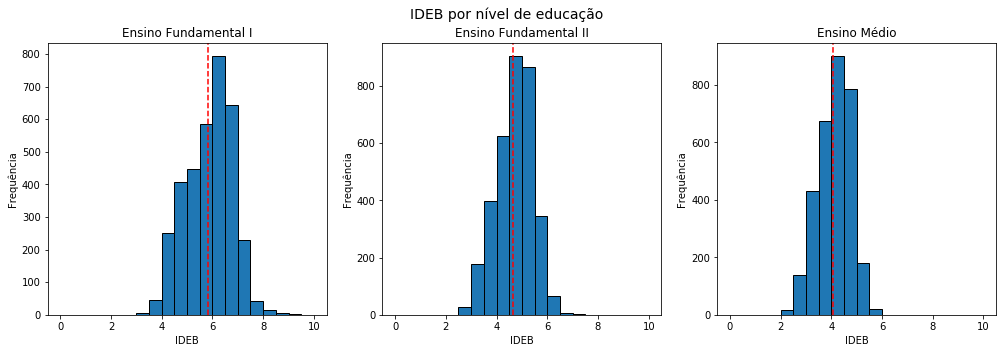

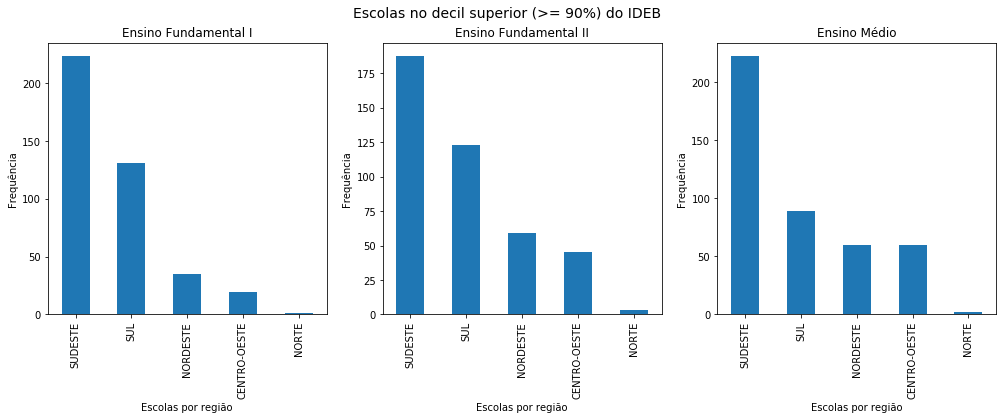

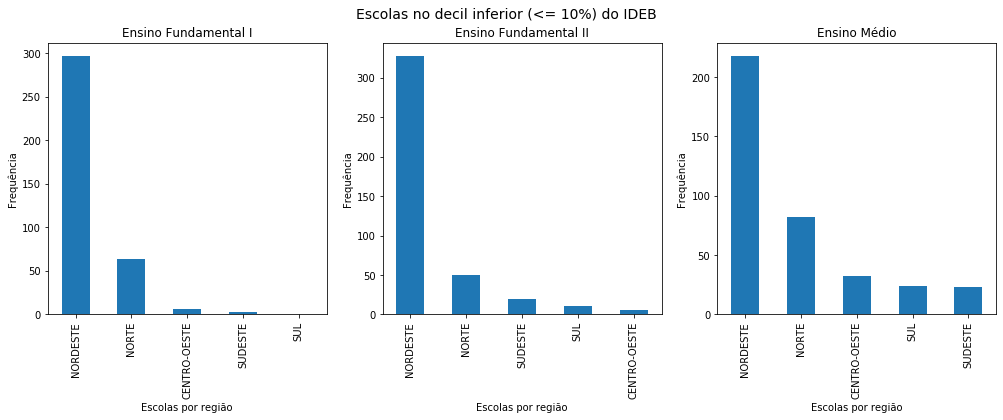

In [10]:
histograma_educacao(
    df=df.drop_duplicates(subset=cols_educacao),
    key='ideb',
    title=u'IDEB por nível de educação',
    xlabel=u'IDEB',
    bins=[
        np.linspace(0, 10, 21),
        np.linspace(0, 10, 21),
        np.linspace(0, 10, 21)
    ]
)

histograma_educacao_decil(
    df=df.drop_duplicates(subset=cols_educacao),
    key='ideb',
    decil=0.9,
    title=u'Escolas no decil superior (>= 90%) do IDEB',
    xlabel=u'Escolas por região'
)

histograma_educacao_decil(
    df=df.drop_duplicates(subset=cols_educacao),
    key='ideb',
    decil=-0.1,
    title=u'Escolas no decil inferior (<= 10%) do IDEB',
    xlabel=u'Escolas por região'
)

#### Taxas de aprovação

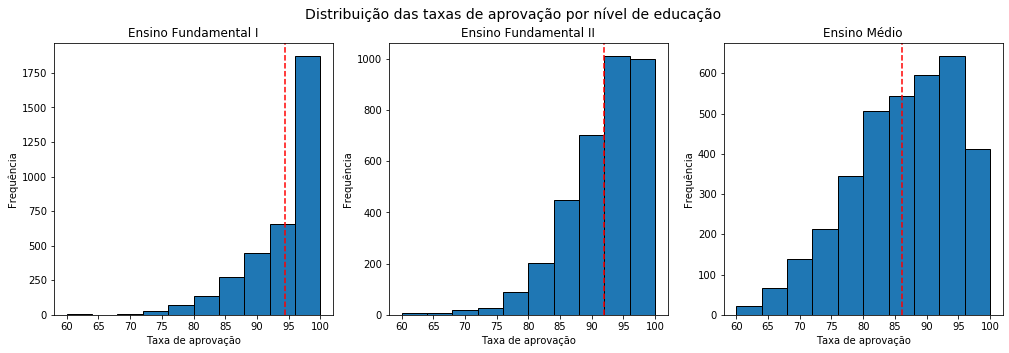

In [11]:
histograma_educacao(
    df=df.drop_duplicates(subset=cols_educacao),
    key='tx_aprov',
    title=u'Distribuição das taxas de aprovação por nível de educação',
    xlabel=u'Taxa de aprovação'
)

#### SAEB - Matemática

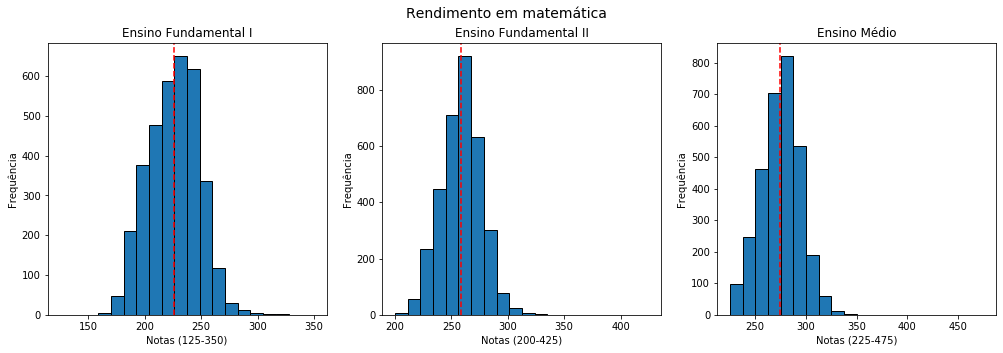

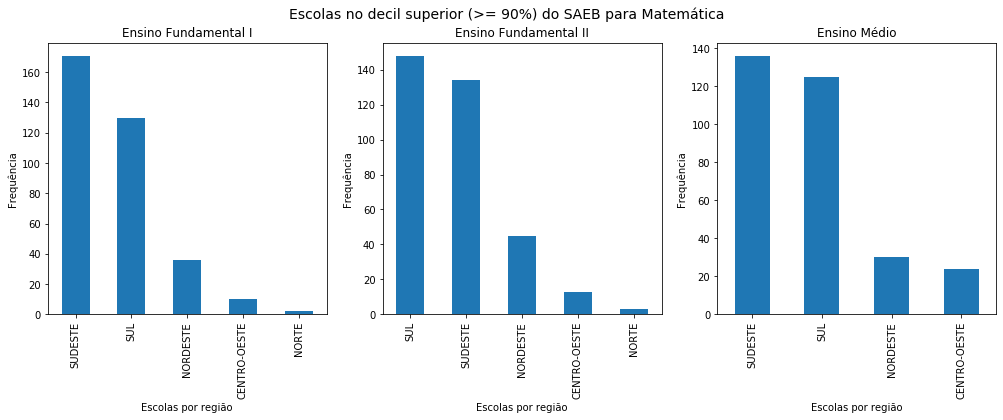

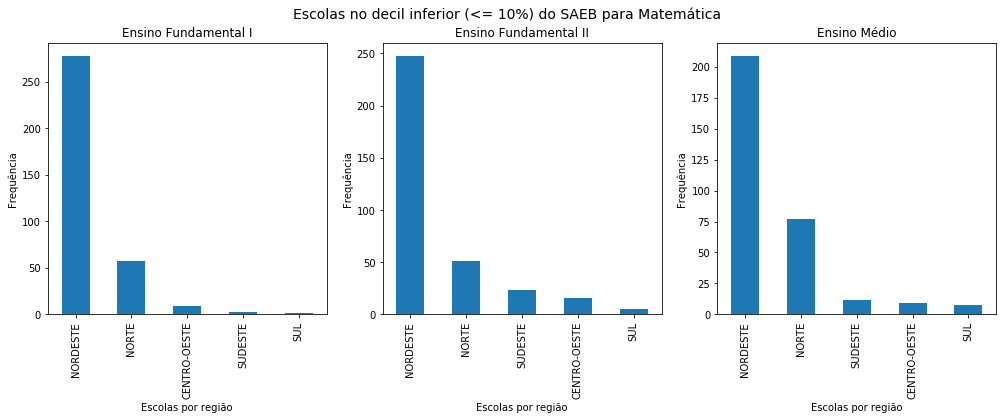

In [12]:
histograma_educacao(
    df=df.drop_duplicates(subset=cols_educacao),
    key='saeb_mat',
    title=u'Rendimento em matemática',
    xlabel=[
        u'Notas (125-350)',
        u'Notas (200-425)',
        u'Notas (225-475)'
    ],
    bins=[
        np.linspace(125, 350, 21),
        np.linspace(200, 425, 21),
        np.linspace(225, 475, 21)
    ]
)

histograma_educacao_decil(
    df=df.drop_duplicates(subset=cols_educacao),
    key='saeb_mat',
    decil=0.9,
    title=u'Escolas no decil superior (>= 90%) do SAEB para Matemática',
    xlabel=u'Escolas por região'
)

histograma_educacao_decil(
    df=df.drop_duplicates(subset=cols_educacao),
    key='saeb_mat',
    decil=-0.1,
    title=u'Escolas no decil inferior (<= 10%) do SAEB para Matemática',
    xlabel=u'Escolas por região'
)

#### SAEB - Língua Portuguesa

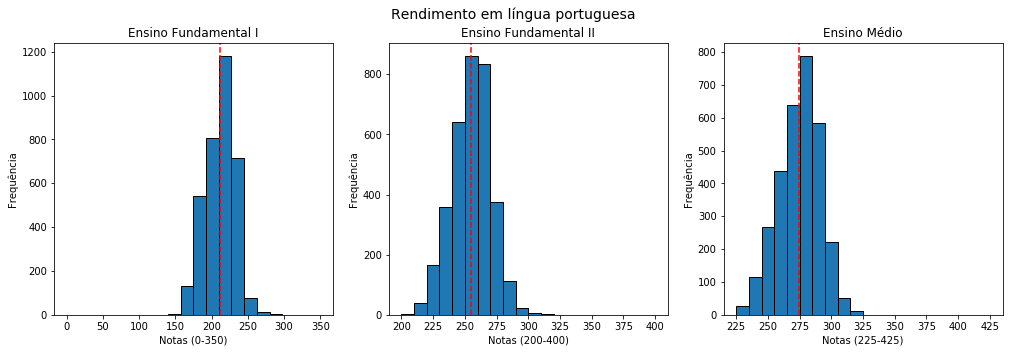

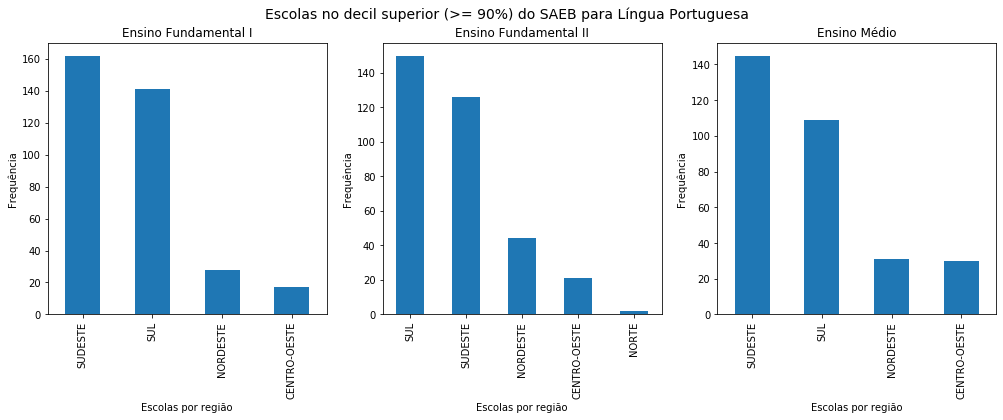

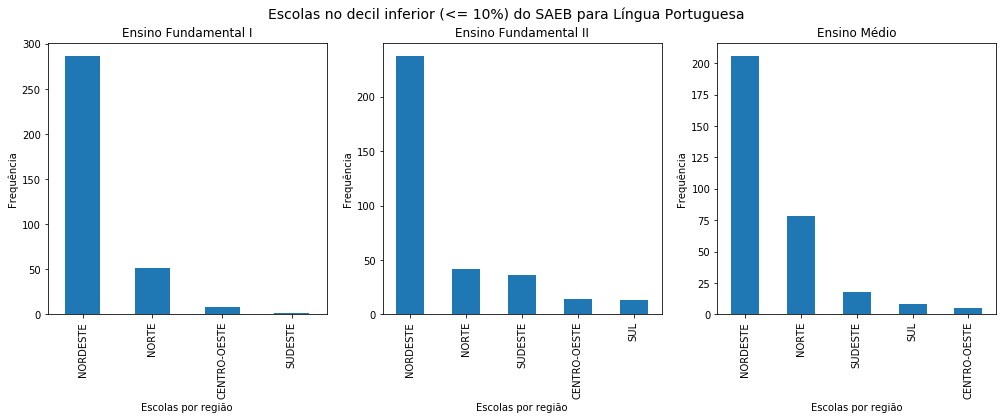

In [13]:
histograma_educacao(
    df=df.drop_duplicates(subset=cols_educacao),
    key='saeb_port',
    title=u'Rendimento em língua portuguesa',
    xlabel=[
        u'Notas (0-350)',
        u'Notas (200-400)',
        u'Notas (225-425)'
    ],
    bins=[
        np.linspace(0, 350, 21),
        np.linspace(200, 400, 21),
        np.linspace(225, 425, 21)
    ]
)

histograma_educacao_decil(
    df=df.drop_duplicates(subset=cols_educacao),
    key='saeb_port',
    decil=0.9,
    title=u'Escolas no decil superior (>= 90%) do SAEB para Língua Portuguesa',
    xlabel=u'Escolas por região'
)

histograma_educacao_decil(
    df=df.drop_duplicates(subset=cols_educacao),
    key='saeb_port',
    decil=-0.1,
    title=u'Escolas no decil inferior (<= 10%) do SAEB para Língua Portuguesa',
    xlabel=u'Escolas por região'
)

### Conclusões

À exceção do indicador de Taxas de Aprovação, as variáveis observadas tem formato aproximadamente de sino aparentemente bem distribuída ao redor da média – linha pontilhada em vermelho. 

Como um todo, observamos que:

1. Os indicadores *deterioram-se* à medida em que se avança pelos níveis de educação

A concentração de pontos desloca-se à esquerda do eixo x entre o Ensino Fundamental I e Ensino Médio.

2. Ao observamos as caudas da distribuição por região – isto é, a contagem de escolas por região cujo desempenho seja superior a 90% ou inferior a 10% das demais do país –, notamos que as escolas de maior desempenho estão fortemente concentradas no eixo sul-sudeste, e as de menor desempenho, no eixo norte-nordeste.    

Em alguns indicadores, a região norte sequer possui cidades de média suficientemente grande para que se enquadre no decil superior. Isto acontece mais frequentemente ao observarmos os dados referentes ao ensino básico.

## 3.2. Dados de Internet

### Visão geral

As variáveis a seguir foram coletadas a partir do mapa do [SIMET](https://simet.nic.br/mapas-app.html). A plataforma disponibiliza estatísticas de testes de velocidade de acesso à Internet para uma pequena região e categoriza os resultados em:

1. operadora do serviço
2. faixa de velocidade, em Mb/s
3. tipo de conexão: `mobile` (redes móveis) ou `broadband` (banda larga fixa)

De posse dos dados, agregamos as estatísticas coletadas por município e tipo de conexão, contabilizando o número de operadoras únicas e o total de dispositivos por faixa. Para as variáveis de dispositivos por faixa, ainda normalizamos os resultados pela população, a fim de tornar as regiões comparáveis entre si – isto é, a variável está na unidade *dispositivos na faixa n por habitante*. Assim, a variável `type` é categórica, enquanto que as variáveis `tcp_range_<n>` (`<n>` representa a faixa de velocidade) e `num_operadoras` são numéricas – respectivamente, contínuas e discreta.

In [8]:
df[cols_internet + ['num_operadoras']].drop_duplicates(subset=cols_internet).describe()

,0_a_2_mbs,2.5_a_5_mbs,6_a_10_mbs,11_a_15_mbs,15_a_25_mbs,acima_25_mbs,num_operadoras
count,3215.000000,3215.000000,3215.000000,3215.000000,3215.000000,3215.000000,3215.000000
mean,308.065941,106.505132,169.086781,249.284603,230.753033,877.254743,5.720684
std,3561.949655,1430.450885,2013.674015,2921.167275,3456.588564,16091.869784,9.615527
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,17.000000,2.000000,6.000000,10.000000,4.000000,12.000000,4.000000
75%,76.000000,26.000000,40.000000,54.000000,40.000000,90.500000,6.000000
max,142096.000000,66577.000000,85348.000000,110248.000000,174895.000000,851533.000000,352.000000


In [9]:
cols_internet

['0_a_2_mbs',
 '2.5_a_5_mbs',
 '6_a_10_mbs',
 '11_a_15_mbs',
 '15_a_25_mbs',
 'acima_25_mbs']

### Visualização dos dados

In [22]:
df[cols_internet + ['regiao']].groupby('regiao').mean()

,0_a_2_mbs,2.5_a_5_mbs,6_a_10_mbs,11_a_15_mbs,15_a_25_mbs,acima_25_mbs
regiao,,,,,,
CENTRO-OESTE,154.105634,46.582160,89.225352,133.075117,89.793427,492.091549
NORDESTE,111.970760,47.964912,84.017544,96.376462,101.285819,239.465643
NORTE,144.209386,49.288809,76.657040,92.588448,96.631769,311.646209
SUDESTE,377.100230,123.711982,183.993664,294.856567,266.080645,1109.178571
SUL,78.107895,26.250000,45.253509,69.214912,68.628947,241.375439


In [26]:
df[df['regiao']=='NORTE'][cols_internet].mean()

0_a_2_mbs       144.209386
2.5_a_5_mbs      49.288809
6_a_10_mbs       76.657040
11_a_15_mbs      92.588448
15_a_25_mbs      96.631769
acima_25_mbs    311.646209
dtype: float64

In [62]:
df.groupby('regiao')[cols_internet[0]].mean()

regiao
CENTRO-OESTE    154.105634
NORDESTE        111.970760
NORTE           144.209386
SUDESTE         377.100230
SUL              78.107895
Name: 0_a_2_mbs, dtype: float64

In [66]:
def histograma_internet(df, title, xlabel, ylabel=u'Frequência'):    
    fig, ax = plt.subplots(6, figsize=(17, 25))
    cols_internet =  [x for x in df.columns.tolist() if 'mbs' in x]
    regioes = ['CENTRO-OESTE', 'NORDESTE', 'NORTE', 'SUDESTE', 'SUL']
    
    for i in range(len(cols_internet)):
        ax[i].bar(regioes, df.groupby('regiao')[cols_internet[i]].mean())
    
    plt.show()

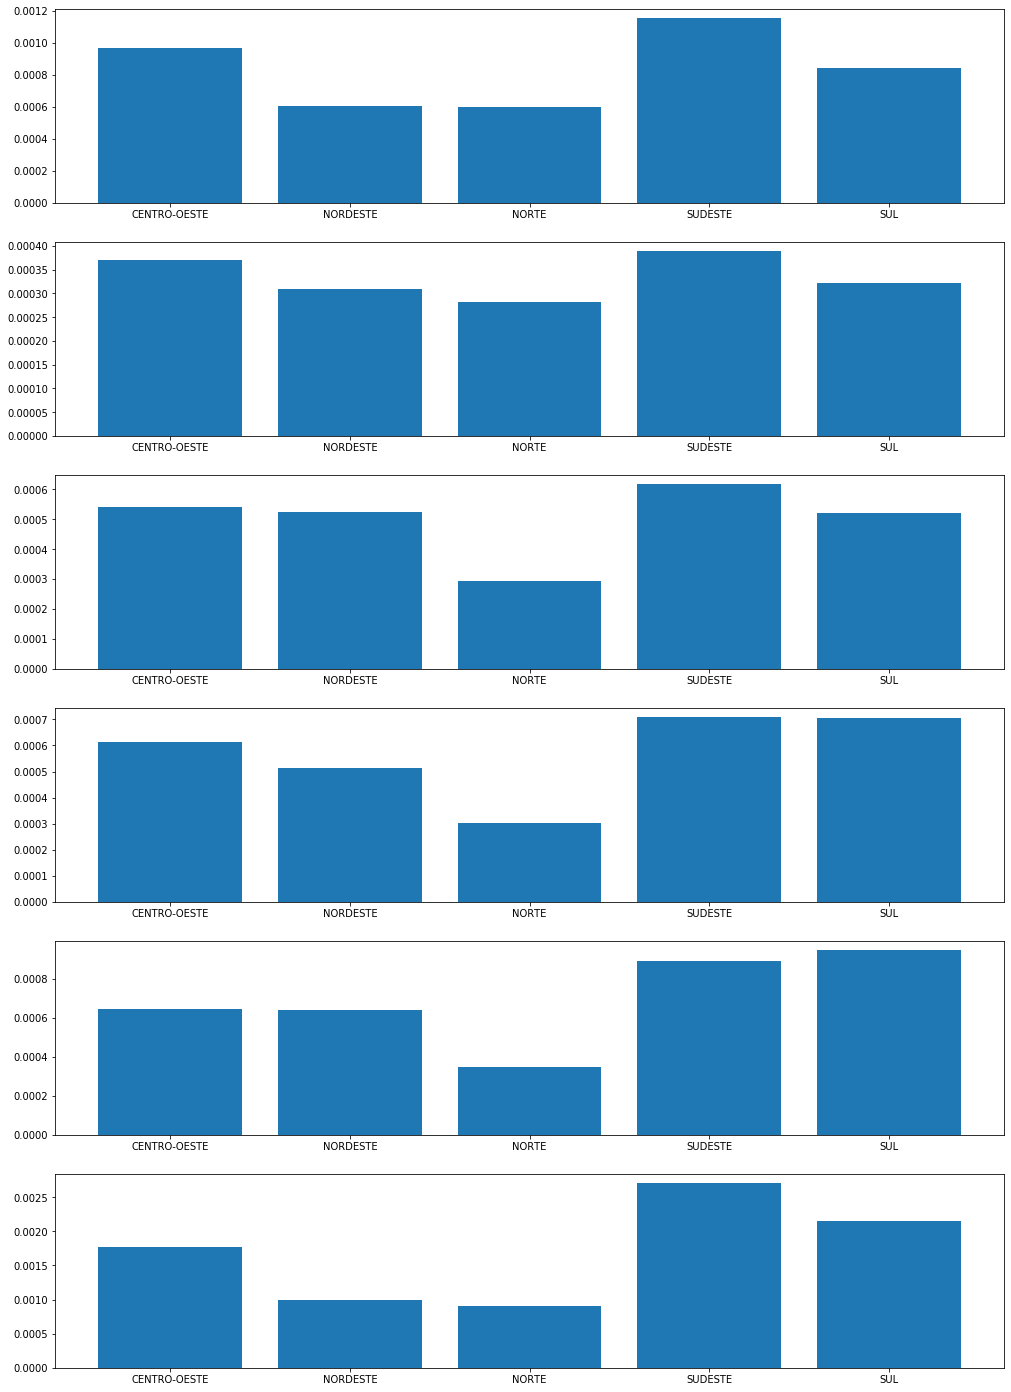

In [72]:
histograma_internet(
    df=df,
    title='teste',
    xlabel='123'
)

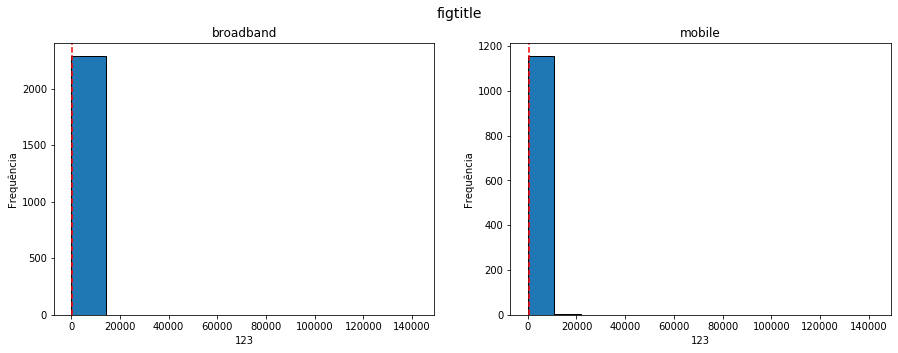

In [11]:
histograma_internet(
    df=df,
    titles=[
        'broadband',
        'mobile',
        'figtitle'
    ],
    xlabel='123',
    key='0_a_2_mbs'
)

## 3.3. Indicadores sociais

### Visão geral

As colunas do conjunto de indicadores sociais são todas numéricas e contínuas. Suas unidades de medida são

| Variável  | Unidade de medida     | Observações     |
| :-------- | --------------------- | ------------------ |
| `populacao` | Número de indivíduos | Dados do Censo de 2010 |
| `exp_vida`  | Média de anos | Esperança de vida ao nascer |
| `analfabetismo` | Analfabetos por 1000 habitantes | Pessoas que de 15 anos ou mais que não sabem ler ou escrever ao menos um bilhete simples |
| `tx_pobreza` | Percentual da população | Pessoas vivendo com menos de USD 5,5 PPC (paridade de poder de compra) por mês |
| `pib_per_capita` | Milhares de BRL por habitante | Em BRL (2016) |
| `mortalidade_inf` | Mortalidade de crianças por 1000 habitantes | Considera crianças que morreram antes de completar 1 ano de vida | 
| `maternidade_inf` | Percentual de meninas que tiveram filhos | Meninas de 10 a 14 anos de idade |

In [14]:
df[cols_social].drop_duplicates(subset=cols_social).describe()

,populacao,exp_vida,analfabetismo,tx_pobreza,pib_per_capita,mortalidade_inf,maternidade_inf
count,3.519000e+03,3519.000000,3519.000000,3518.000000,3519.000000,3479.000000,2570.000000
mean,4.960086e+04,73.479639,14.497772,19.983215,15.292072,12.535979,1.144510
std,2.541274e+05,2.619600,9.534695,16.553294,13.894857,10.020311,0.814985
min,1.096000e+03,65.490000,0.950000,0.190000,3.220000,0.000000,0.050000
25%,8.506500e+03,71.600000,6.935000,5.922500,6.800000,6.670000,0.542500
50%,1.709300e+04,73.890000,11.120000,13.080000,11.980000,11.630000,0.940000
75%,3.433550e+04,75.470000,21.890000,34.170000,18.960000,16.850000,1.500000
max,1.125350e+07,78.640000,42.860000,67.870000,208.900000,142.860000,6.110000


### Visualização dos dados

In [15]:
def histograma_social(df, key, title, xlabel, ylabel=u'Frequência', legend=None, regional=False, agg_method=None, bins=None):
    df = df.dropna()
    fig, ax = plt.subplots(figsize=(15, 5))
    
    if not regional:
        if bins is not None:
            ax.hist(df[key], edgecolor='black', bins=bins)
        else:
            ax.hist(df[key], edgecolor='black')
        ax.axvline(df[key].mean(), color='red', linestyle='--')
    else:
        df.groupby('regiao').agg({
            key: agg_method
        }).plot.bar(ax=ax)
        if legend:
            ax.legend([legend])
        else:
            ax.get_legend().remove()
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
        
    plt.title(title, fontsize=14)
    plt.show()

#### População por região

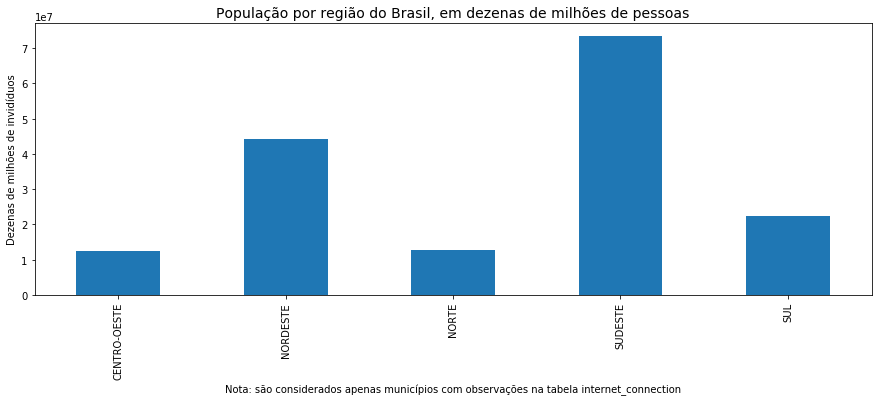

In [16]:
histograma_social(
    df=df[cols_social + ['regiao']].drop_duplicates(),
    key='populacao',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Dezenas de milhões de invidíduos',
    title=u'População por região do Brasil, em dezenas de milhões de pessoas',
    regional=True,
    agg_method='sum'
)

#### Expectativa de vida

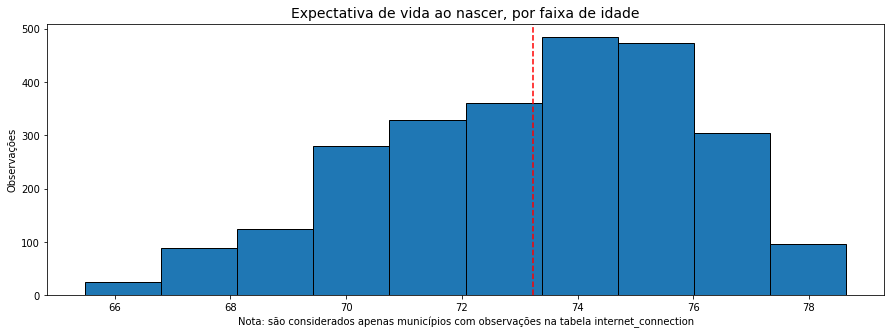

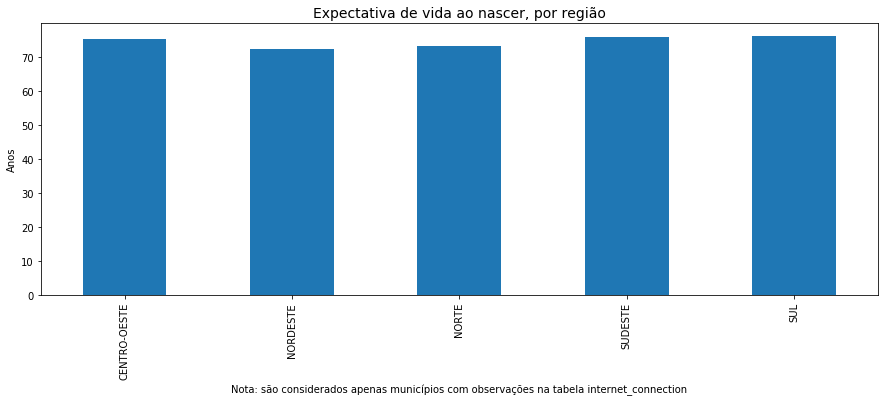

In [17]:
histograma_social(
    df=df[cols_social].drop_duplicates(),
    key='exp_vida',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Observações',
    title=u'Expectativa de vida ao nascer, por faixa de idade'
)

histograma_social(
    df=df[cols_social + ['regiao']].drop_duplicates(),
    key='exp_vida',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Anos',
    title=u'Expectativa de vida ao nascer, por região',
    regional=True,
    agg_method=lambda x: np.average(x, weights=df.loc[x.index, 'populacao'])
)

#### Analfabetismo

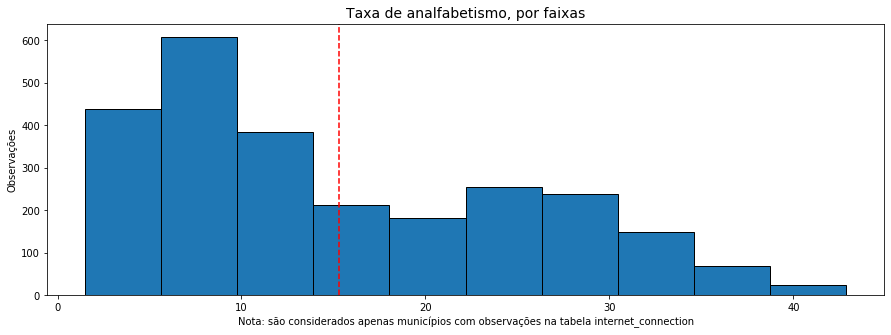

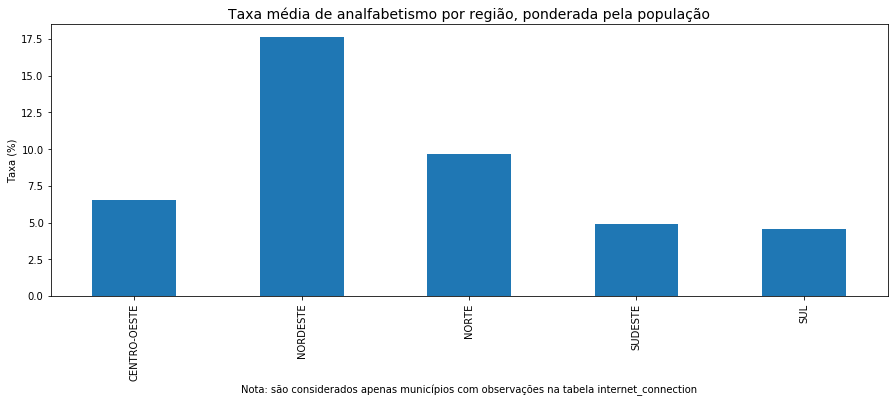

In [18]:
histograma_social(
    df=df[cols_social].drop_duplicates(),
    key='analfabetismo',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Observações',
    title=u'Taxa de analfabetismo, por faixas'
)

histograma_social(
    df=df[cols_social + ['regiao']].drop_duplicates(),
    key='analfabetismo',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Taxa (%)',
    title=u'Taxa média de analfabetismo por região, ponderada pela população',
    regional=True,
    agg_method=lambda x: np.average(x, weights=df.loc[x.index, 'populacao'])
)

#### Taxa de Pobreza

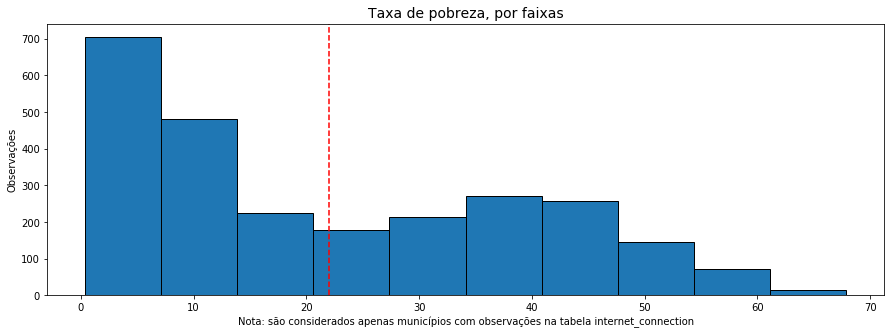

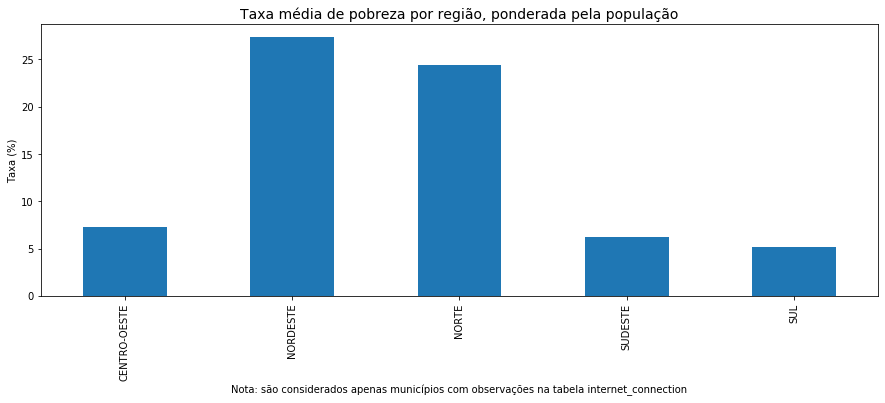

In [19]:
histograma_social(
    df=df[cols_social].drop_duplicates(),
    key='tx_pobreza',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Observações',
    title=u'Taxa de pobreza, por faixas'
)

histograma_social(
    df=df[cols_social + ['regiao']].drop_duplicates(),
    key='tx_pobreza',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Taxa (%)',
    title=u'Taxa média de pobreza por região, ponderada pela população',
    regional=True,
    agg_method=lambda x: np.average(x, weights=df.loc[x.index, 'populacao'])
)

#### PIB per capita

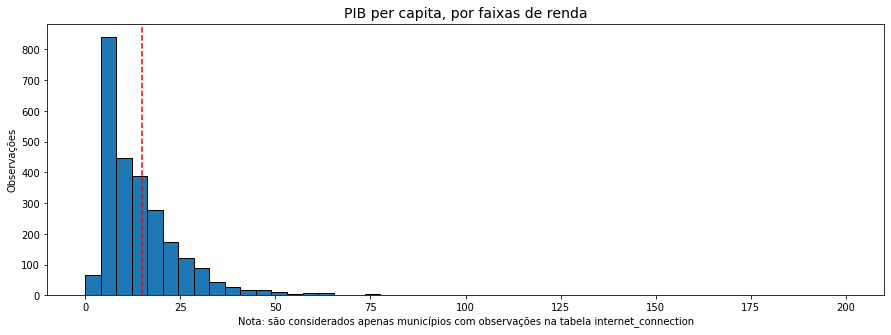

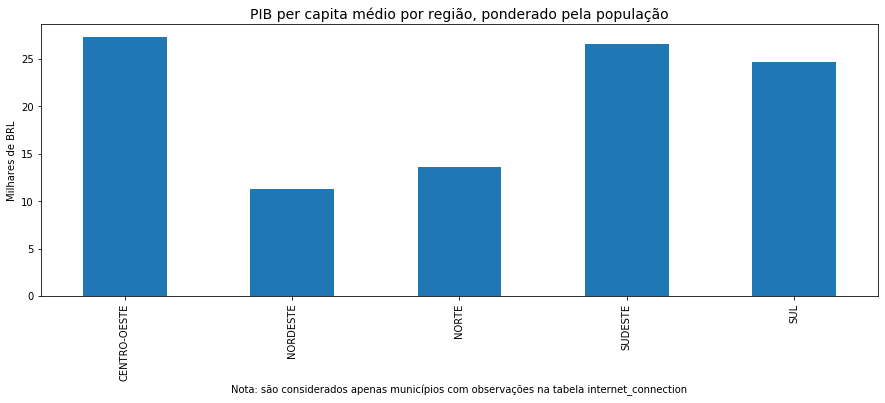

In [20]:
histograma_social(
    df=df[cols_social].drop_duplicates(),
    key='pib_per_capita',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Observações',
    title=u'PIB per capita, por faixas de renda',
    bins=np.linspace(0, 200, 50)
)

histograma_social(
    df=df[cols_social + ['regiao']].drop_duplicates(),
    key='pib_per_capita',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Milhares de BRL',
    title=u'PIB per capita médio por região, ponderado pela população',
    regional=True,
    agg_method=lambda x: np.average(x, weights=df.loc[x.index, 'populacao'])
)

#### Mortalidade infantil

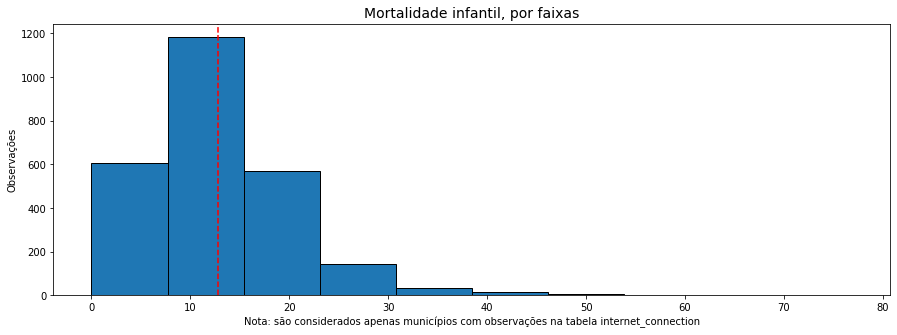

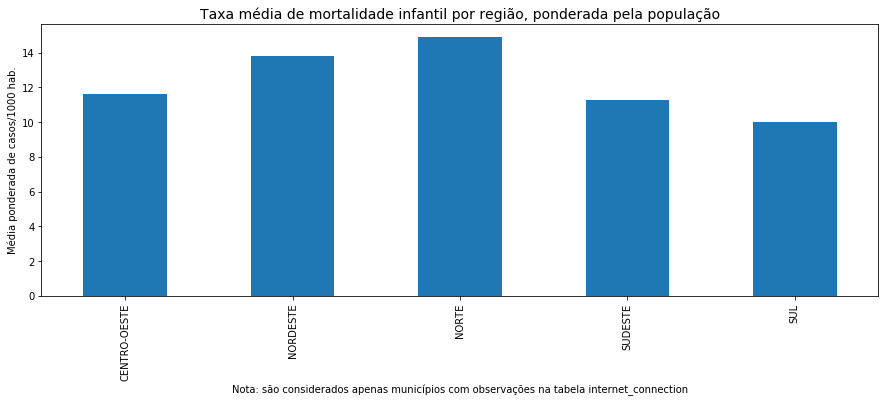

In [21]:
histograma_social(
    df=df[cols_social].drop_duplicates(),
    key='mortalidade_inf',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Observações',
    title=u'Mortalidade infantil, por faixas'
)

histograma_social(
    df=df[cols_social + ['regiao']].drop_duplicates(),
    key='mortalidade_inf',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Média ponderada de casos/1000 hab.',
    title=u'Taxa média de mortalidade infantil por região, ponderada pela população',
    regional=True,
    agg_method=lambda x: np.average(x, weights=df.loc[x.index, 'populacao'])
)

#### Gravidez na adolescência

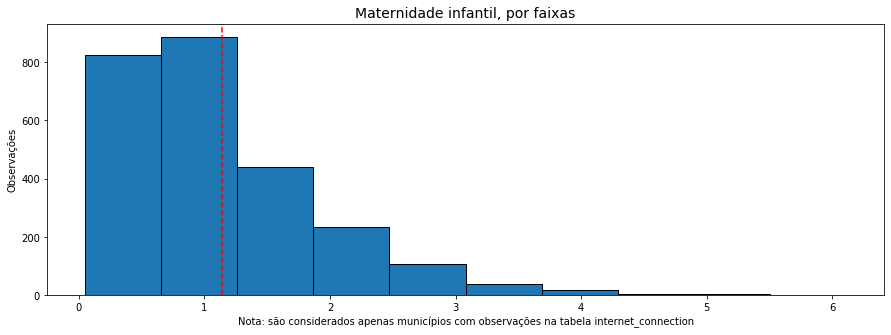

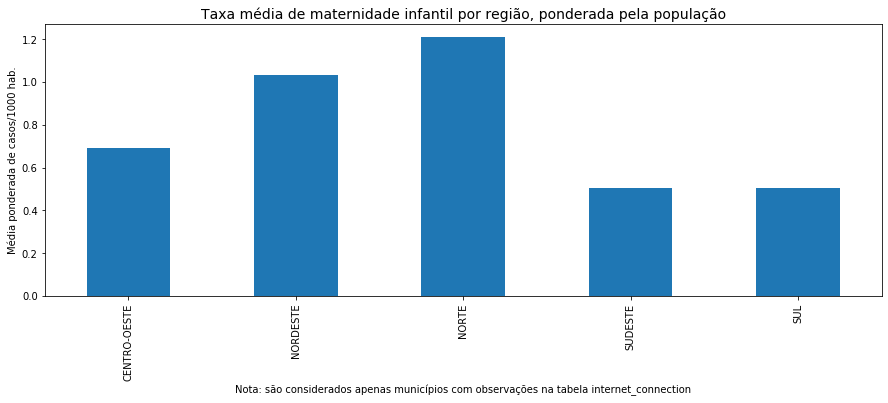

In [22]:
histograma_social(
    df=df[cols_social].drop_duplicates(),
    key='maternidade_inf',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Observações',
    title=u'Maternidade infantil, por faixas'
)

histograma_social(
    df=df[cols_social + ['regiao']].drop_duplicates(),
    key='maternidade_inf',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Média ponderada de casos/1000 hab.',
    title=u'Taxa média de maternidade infantil por região, ponderada pela população',
    regional=True,
    agg_method=lambda x: np.average(x, weights=df.loc[x.index, 'populacao'])
)

### Conclusões

Os indicadores sociais apresentados servirão de variáveis de controle para a regressão. Antes que apresentemos qualificações sobre as regiões, é necessário frisar que os resultados apresentam certo viés que favorece as regiões Sul e Sudeste: como consideramos apenas as cidades que possuam ao menos 1 registro de teste de velocidade – e dada a concentração da infraestrutura de Internet nessa região –, existirão mais observações para cidades pertencentes a este eixo. Assim, os conclusões devem ser interpretadas com cautela.

Em termos de indicadores, nota-se que o Sudeste, além de concentrar a maior população considerada, também concentra os melhores resultados em todos os indicadores considerados, e o Sul tem desempenho similar. As regiões Norte e Nordeste, por outro lado, encontram-se na situação oposta: seus resultados são todos inferiores às regiões anteriores. A isto certamente está associada a distribuição de riqueza per capita no país, que está diretamente correlacionada ao bom desempenho nestes indicadores. Como caso atípico ao padrão constatado, temos apenas a expectativa de vida: apesar de todas as disparidades pontuadas, a esperança de vida média é muito similar entre todas as regiões – e a amplitude de observações é menor que a das demais variáveis.

### Conclusões

**escrever conclusões aqui**

## 3.4. Correlações relevantes